# Trabajo práctico integrador - Aprendizaje de Máquina I

## Carrera de Especialización en Inteligencia Artificial / 23Co2025

### Alumnos:

* Paola Andrea Blanco     **(a2303)**
* Facundo Manuel Quiroga  **(a2305)**
* Juan Manuel Fajardo     **(a2310)**
* Victor Gabriel Peralta  **(a2322)**
* Agustín Jesús Vazquez   **(e2301)**

## 1. Introducción y objetivo de trabajo

**Fuente de información de evaluación:** Utilizaremos el dataset [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package), el cual comprende aproximadamente 10 años de observaciones diarias del clima en numerosos lugares de Australia.

**Objetivo:** Queremos predecir si lloverá o no al día siguiente en función de datos meteorológicos del día actual, para integrar esta información en una aplicación meteorológica que beneficie al público.

In [1]:
# Importamos librerías necesarias para el desarrollo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)  # Mostrar todas las columnas al imprimir un DataFrame

## 2. Carga de datos y análisis exploratorio (EDA)

En esta sección cargamos el conjunto de datos original y realizamos un breve análisis exploratorio para entender su estructura, distribuciones y valores faltantes.

In [2]:
# Cargar dataset
df = pd.read_csv('dataset/weatherAUS.csv')

In [3]:
# Dimensiones del DataFrame
print("Dimensiones del DataFrame:", df.shape)

Dimensiones del DataFrame: (145460, 23)


In [4]:
df.info()  # Tipos de datos de cada columna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Análisis Missing

In [5]:
# function to display missing values
def display_missing_values(dataframe):
     missing = dataframe.isnull().sum()
     missing = missing[missing > 0]
     missing_percentage = (missing / len(dataframe)) * 100
     missing_df = pd.DataFrame({'missing_count': missing, 'missing_percentage': missing_percentage})
     return missing_df.sort_values(by='missing_percentage', ascending=False)

# Mostrar valores faltantes
missing_values = display_missing_values(df)
print("Valores faltantes en el DataFrame:\n", missing_values)

Valores faltantes en el DataFrame:
                missing_count  missing_percentage
Sunshine               69835           48.009762
Evaporation            62790           43.166506
Cloud3pm               59358           40.807095
Cloud9am               55888           38.421559
Pressure9am            15065           10.356799
Pressure3pm            15028           10.331363
WindDir9am             10566            7.263853
WindGustDir            10326            7.098859
WindGustSpeed          10263            7.055548
Humidity3pm             4507            3.098446
WindDir3pm              4228            2.906641
Temp3pm                 3609            2.481094
RainTomorrow            3267            2.245978
Rainfall                3261            2.241853
RainToday               3261            2.241853
WindSpeed3pm            3062            2.105046
Humidity9am             2654            1.824557
WindSpeed9am            1767            1.214767
Temp9am                 1767     

Tenemos 4 features con más de 30% de missings que serían candidatas a ser dropeadas:
* Sunshine 48%, Evaporation 43%, Cloud3pm 40% y Cloud9am 38%

Asimismo tenemos ~2% de missing en RainTomorrow que es nuestra variable target. Dado que, tenemos relativamente pocos missing, y, además, están distribuidos a lo largo del tiempo, dropearemos estas filas, y lo guarderemos en un nuevo dataframe

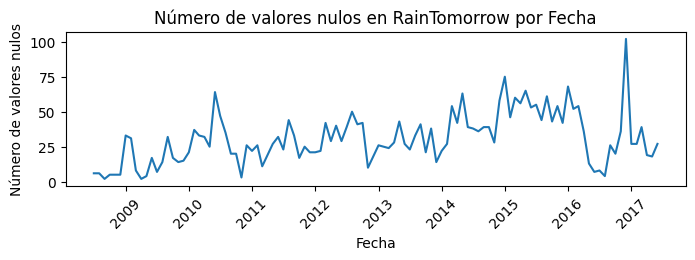

In [6]:
# nulls by Date for RainTomorrow column
df_graph = df.groupby('Date')['RainTomorrow'].apply(lambda x: x.isna().sum()).sort_values(ascending=False)
df_graph = df_graph[df_graph > 0]  # Filtrar solo fechas con valores nulos
# truncate mes/year
df_graph.index = pd.to_datetime(df_graph.index).to_period('M').to_timestamp()
df_graph = df_graph.groupby(df_graph.index).sum()

plt.figure(figsize=(8, 2))
plt.plot(df_graph.index, df_graph.values)
plt.title('Número de valores nulos en RainTomorrow por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de valores nulos')
plt.xticks(rotation=45)
plt.show()


In [7]:
# Crear un nuevo data frame con Raintomorrow and RainToday sin missings
df_clean = df.dropna(subset=['RainTomorrow','RainToday']).copy()

# Verificar que no hay missings en RainTomorrow
print("Missing en RainTomorrow: ",df_clean['RainTomorrow'].isna().sum())
print("Missing en RainToday: ",df_clean['RainToday'].isna().sum())

Missing en RainTomorrow:  0
Missing en RainToday:  0


<Axes: >

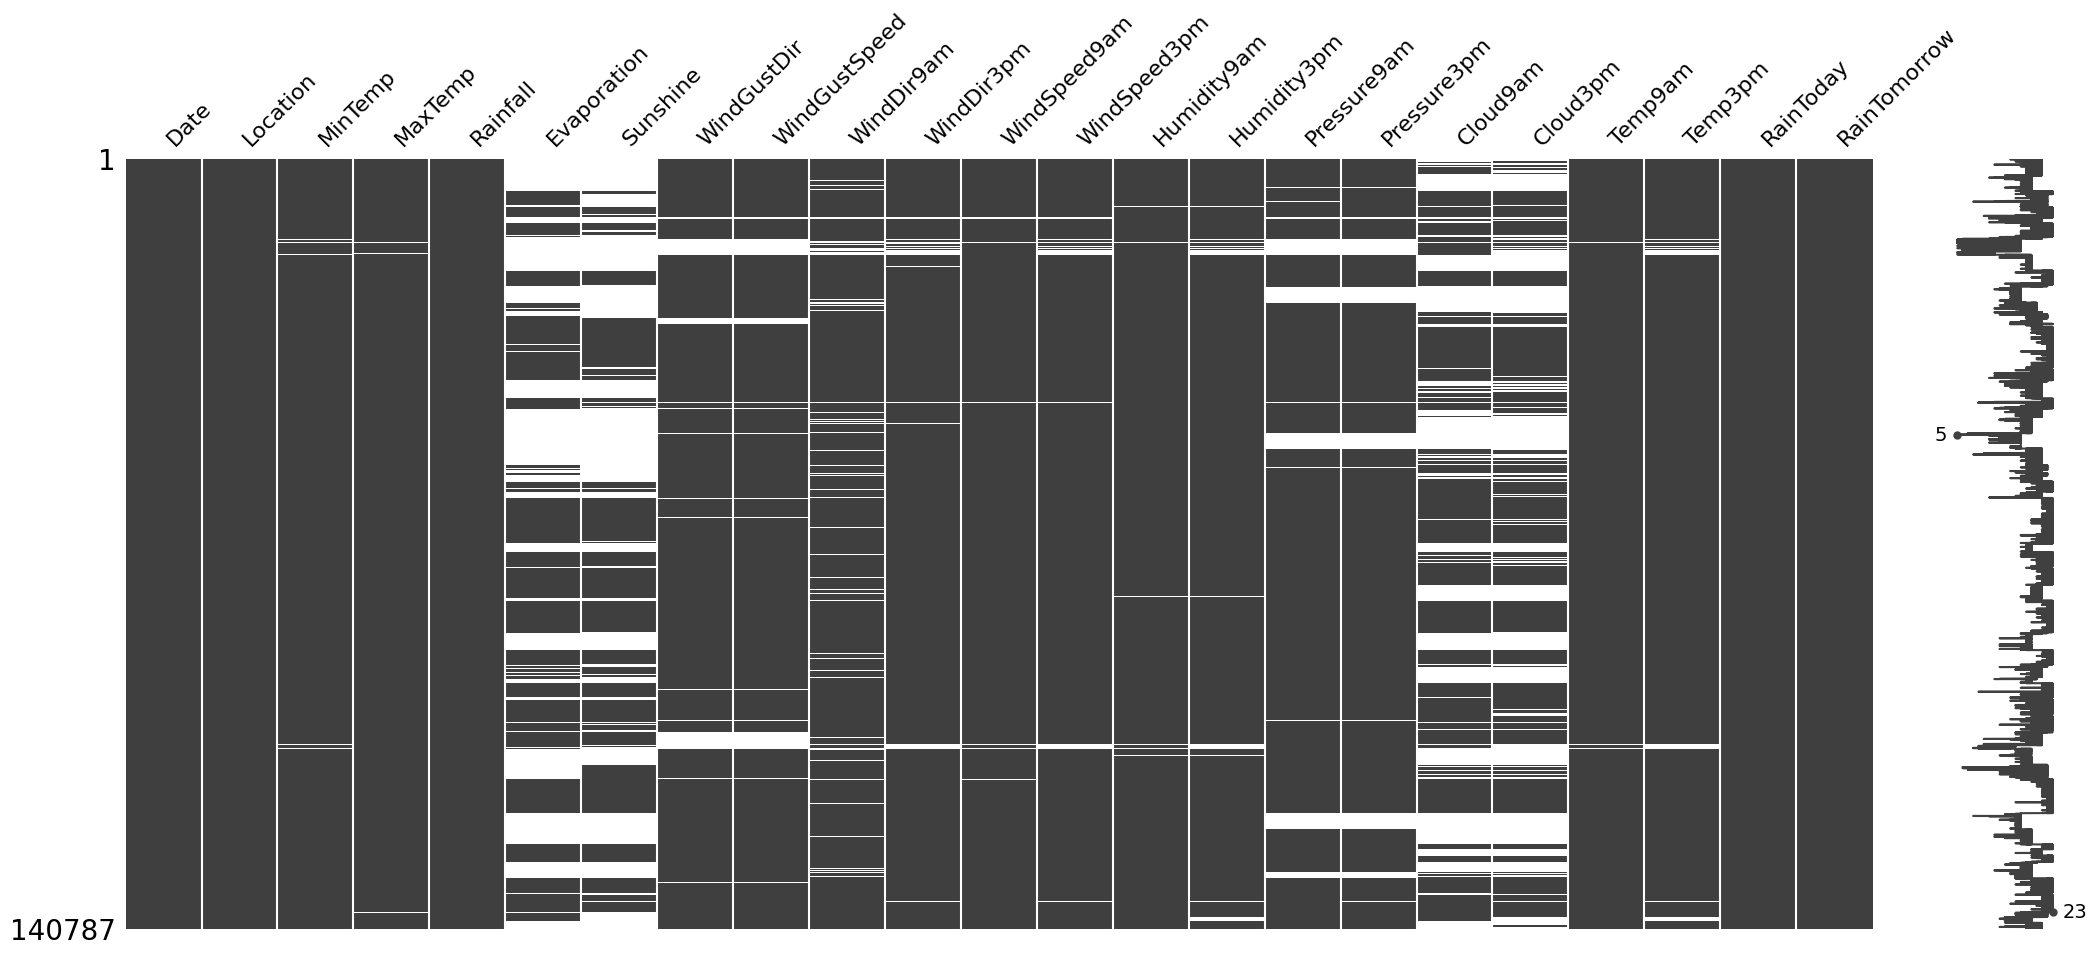

In [8]:
import missingno as msno
# Visualización de datos faltantes
msno.matrix(df_clean)

La matriz de missing values, nos muestra que hay features que coinciden en missings para similares rangos de tiempo y location. Se observa que hay features como: 
* WindGustSpeed y WinGustDir, RainToday y Rainfall, Pressure3pm y Pressure9am que tienen una correlación alta. Esto significa que si un feature está vacío, entonces el otro también estará vacío (idem. completo).

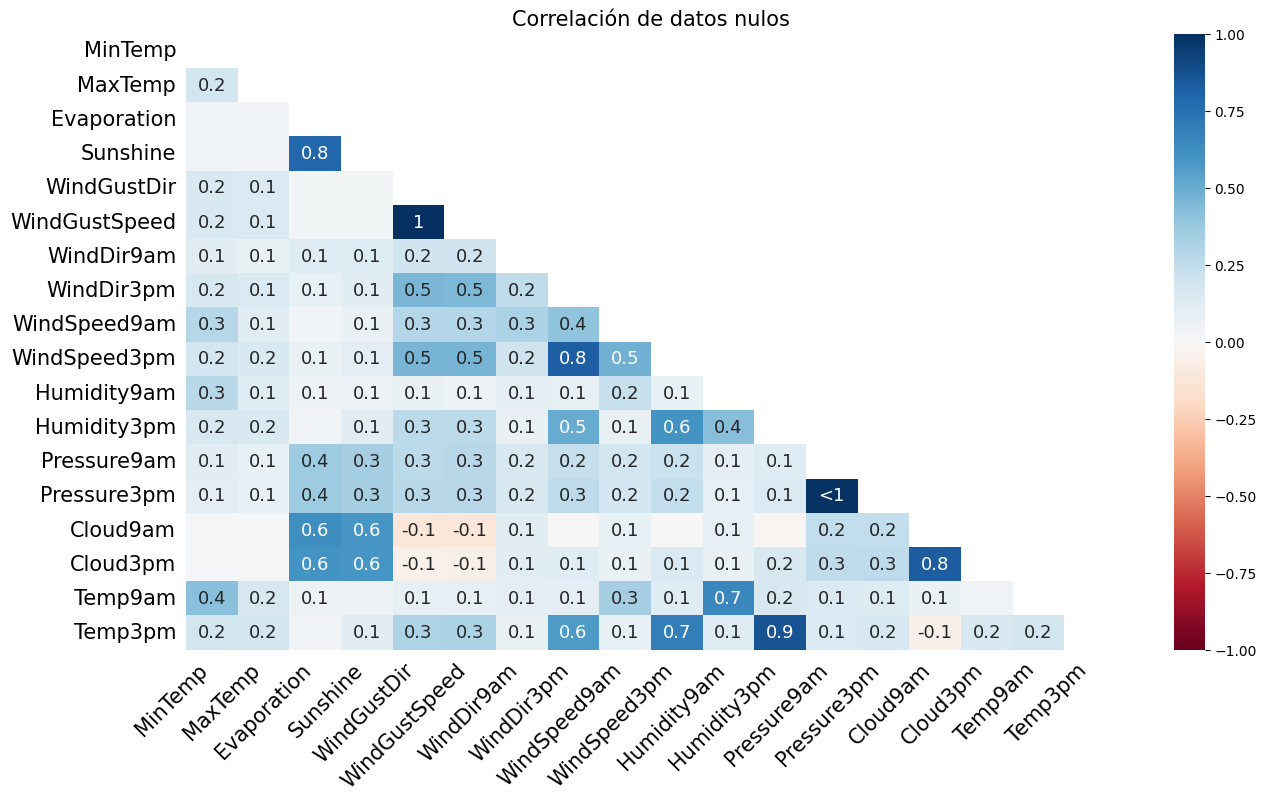

In [9]:
msno.heatmap(df_clean, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

Tenemos 5 Locations donde se concentran los missings para Pressure9am y Pressure3pm: 
* Launceston
* MountGinini
* Newcastle
* Penrith
* Sydney

In [10]:
# Concentración de missings por Location
df_clean.groupby('Location').apply(lambda x: x.isna().sum())

/tmp/ipykernel_52529/2634234325.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean.groupby('Location').apply(lambda x: x.isna().sum())


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Location,,,,,,,,,,,,,,,,,,,,,,,
Adelaide,0,0,1,0,0,1372,1368,20,20,248,14,3,5,3,5,6,7,3020,3020,3,4,0,0
Albany,0,0,39,32,0,270,494,2996,2996,224,748,38,699,26,682,25,24,15,677,16,678,0,0
Albury,0,0,1,1,0,2991,2991,8,8,512,42,1,7,4,4,0,4,1716,1587,4,4,0,0
AliceSprings,0,0,1,1,0,205,505,49,49,229,4,2,2,2,4,1,3,330,354,0,2,0,0
BadgerysCreek,0,0,3,2,0,2877,2877,13,13,369,55,1,19,13,27,128,143,2877,2877,0,16,0,0
Ballarat,0,0,0,1,0,3017,3017,23,23,91,15,8,2,21,5,24,23,540,1036,12,4,0,0
Bendigo,0,0,1,1,0,1845,3030,36,35,243,42,3,3,5,1,14,9,960,764,2,1,0,0
Brisbane,0,0,2,4,0,19,48,12,12,67,27,0,2,2,9,0,2,1,2,2,9,0,0
Cairns,0,0,1,0,0,317,403,18,17,42,4,0,1,0,0,0,0,173,197,0,0,0,0


### Análisis de Outeliers y Descriptivo Univariado

In [11]:
# descriptive statistics function summary for numeric columns

def descriptive_statistics(dataframe):
    ds_df = dataframe.describe().T
    # numeric columns
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns
    # skewness and kurtosis
    for col in numeric_cols:
        ds_df.loc[col, 'skewness'] = dataframe[col].skew()
        ds_df.loc[col, 'excess_kurtosis'] = dataframe[col].kurtosis() # excess kurtosis
    
    # missing values
    ds_df['missing_count'] = dataframe.isnull().sum()
    ds_df['missing_percentage'] = (ds_df['missing_count'] / len(dataframe)) * 100

    # IQR and outliers
    ds_df['IQR'] = ds_df['75%'] - ds_df['25%']
    ds_df['outliers_count'] = 0
    for col in numeric_cols:
        Q1 = ds_df.loc[col, '25%']
        Q3 = ds_df.loc[col, '75%']
        IQR = ds_df.loc[col, 'IQR']
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
        ds_df.loc[col, 'outliers_count'] = outliers.shape[0]
        # percentage of outliers
        ds_df.loc[col, 'outliers_percentage'] = (ds_df.loc[col, 'outliers_count'] / len(dataframe)) * 100

        # sigma rule
        lower_bound_sigma = ds_df.loc[col, 'mean'] - 3 * ds_df.loc[col, 'std']
        upper_bound_sigma = ds_df.loc[col, 'mean'] + 3 * ds_df.loc[col, 'std']
        sigma_outliers = dataframe[(dataframe[col] < lower_bound_sigma) | (dataframe[col] > upper_bound_sigma)]
        ds_df.loc[col, 'sigma_outliers_count'] = sigma_outliers.shape[0]
        # percentage of sigma outliers
        ds_df.loc[col, 'sigma_outliers_percentage'] = (ds_df.loc[col, 'sigma_outliers_count'] / len(dataframe)) * 100
    #print("Descriptive statistics calculated: \n")


    return ds_df

Se realiza un resumen descriptivo con estadísticos de variables numéricas.

Resumen Outliers:
* Usando el criterio del rango intercuartilico, tenemos ~17% de outliers en Rainfall, luego en WindGustSpeed un 2% aproximadamente. En el resto de variables es menor a 2%

Resumen Distribuciones:
* Usando el criterio Skewness y exceso de Kurtosis, tenemos que: 
    * Estas features tienen una distribucion similar a la normal:
        * MaxTemp, MinTemp, Pressure9am, Pressure3pm, Temp3pm, Temp9am
    * Estas features tienen una distribucion asimetrica con colas pesadas
        * Rainfall, Evaporation, WindSpeed9am, WindSpeed3pm, WindGustSpeed
    * Estas features tienen una distribucion asimetrica con colas menos pesadas
        * Humidity9am, Humidity3pm

In [12]:
resumen = descriptive_statistics(df_clean)
display(resumen)

,count,mean,std,min,25%,50%,75%,max,skewness,excess_kurtosis,missing_count,missing_percentage,IQR,outliers_count,outliers_percentage,sigma_outliers_count,sigma_outliers_percentage
MinTemp,140319.0,12.184824,6.403879,-8.5,7.6,12.0,16.8,33.9,0.026180,-0.490481,468,0.332417,9.2,61,0.043328,18.0,0.012785
MaxTemp,140480.0,23.235120,7.114500,-4.8,17.9,22.6,28.3,48.1,0.230173,-0.252785,307,0.218060,10.4,387,0.274883,292.0,0.207406
Rainfall,140787.0,2.349974,8.465173,0.0,0.0,0.0,0.8,371.0,9.888061,180.002097,0,0.000000,0.8,25228,17.919268,2409.0,1.711095
Evaporation,81093.0,5.472516,4.189132,0.0,2.6,4.8,7.4,145.0,3.750062,45.152676,59694,42.400222,4.8,1947,1.382940,853.0,0.605880
Sunshine,73982.0,7.630540,3.781729,0.0,4.9,8.5,10.7,14.5,-0.505034,-0.818324,66805,47.451114,5.8,0,0.000000,0.0,0.000000
WindGustSpeed,131682.0,39.970520,13.578201,6.0,31.0,39.0,48.0,135.0,0.871458,1.405272,9105,6.467216,17.0,2962,2.103887,1314.0,0.933325
WindSpeed9am,139732.0,13.990496,8.886210,0.0,7.0,13.0,19.0,130.0,0.774517,1.226553,1055,0.749359,12.0,1715,1.218152,1290.0,0.916278
WindSpeed3pm,138256.0,18.631141,8.798096,0.0,13.0,19.0,24.0,87.0,0.631407,0.780510,2531,1.797751,11.0,2420,1.718909,921.0,0.654180
Humidity9am,139270.0,68.826833,19.063650,0.0,57.0,70.0,83.0,100.0,-0.482213,-0.040644,1517,1.077514,26.0,1414,1.004354,471.0,0.334548
Humidity3pm,137286.0,51.449288,20.807310,0.0,37.0,52.0,66.0,100.0,0.034406,-0.513322,3501,2.486735,29.0,0,0.000000,0.0,0.000000


In [13]:
# graficas de distribuciones numéricas
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_distributions(dataframe):
    subplot_rows = int(np.ceil(len(dataframe.select_dtypes(include=[np.number]).columns) / 3))
    subplot_cols = 3

    fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 5 * subplot_rows))
    axes = axes.flatten()

    for i, col in enumerate(dataframe.select_dtypes(include=[np.number]).columns):
        sns.histplot(dataframe[col].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f'Distribución de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

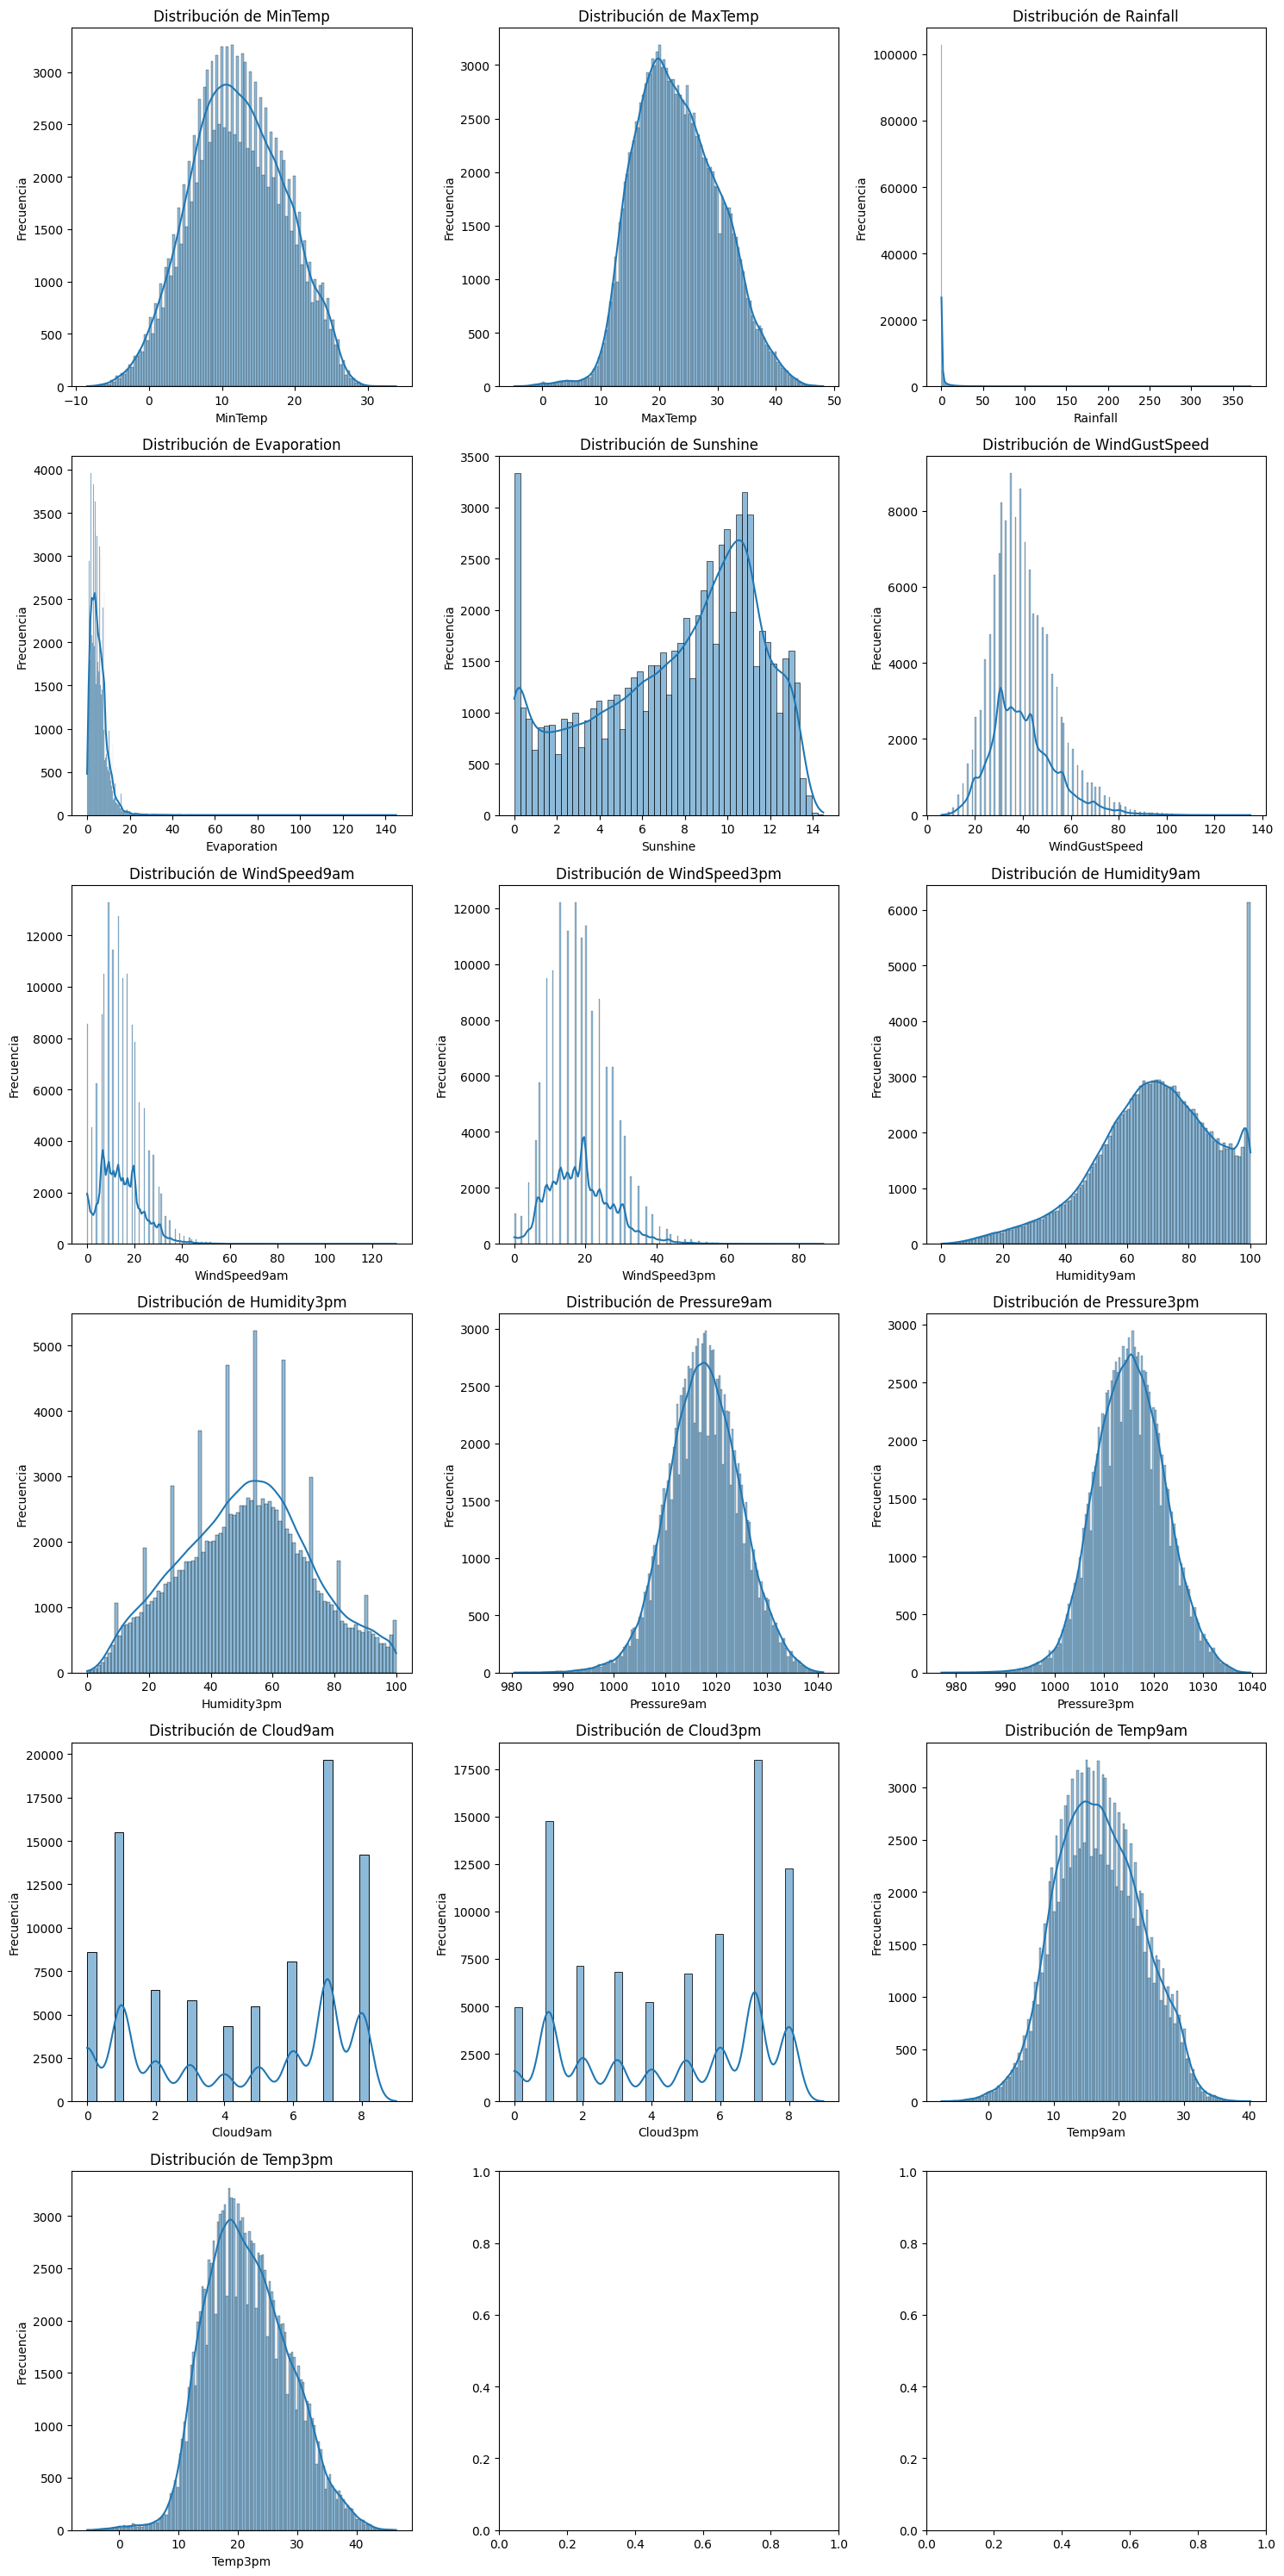

In [14]:
# Llamar a la función para graficar distribuciones numéricas
plot_numeric_distributions(df_clean)


In [15]:
# function to descriptive analysis categorical columns, unique values, missing, mode, entropy, entropy normalized
def descriptive_analysis_categorical(dataframe):
    categorical_cols = dataframe.select_dtypes(include=['object', 'category']).columns
    da_df = pd.DataFrame(index=categorical_cols, columns=['unique_values', 'missing_count','missing_percentage','mode', 'mode_frequency', 'mode_frequency_perc','entropy', 'entropy_normalized'])

    for col in categorical_cols:
        da_df.loc[col, 'unique_values'] = dataframe[col].nunique()
        da_df.loc[col, 'missing_count'] = dataframe[col].isnull().sum()
        da_df.loc[col, 'missing_percentage'] = (da_df.loc[col, 'missing_count'] / len(dataframe)) * 100
        da_df.loc[col, 'mode'] = dataframe[col].mode()[0]
        da_df.loc[col, 'mode_frequency'] = dataframe[col].value_counts().iloc[0]
        da_df.loc[col, 'mode_frequency_perc'] = (da_df.loc[col, 'mode_frequency'] / len(dataframe[col].dropna())) * 100

        # Entropy calculation
        value_counts = dataframe[col].value_counts(normalize=True)
        entropy = -np.sum(value_counts * np.log2(value_counts + 1e-9))  # Adding a small value to avoid log(0)
        da_df.loc[col, 'entropy'] = entropy

        # Normalized entropy
        max_entropy = np.log2(da_df.loc[col, 'unique_values'] + 1e-9)
        da_df.loc[col, 'entropy_normalized'] = entropy / max_entropy if max_entropy > 0 else 0

    display(da_df)

Se realiza un resumen descriptivo para variables categóricas:
* Revisando la entropia normalizada, se oberva que la mayoría tienen features con valores balanceados entre sí (entropia > 99%)
* No obstante, se observa que RainToday y RainTomorrow (target) tienen un entropía normalizada en 76%, esto nos da indicios de desbalance de datos. Además, si vemos que 77% de casos son No, entonces, observa un caso de ligero desbalance.

In [16]:
descriptive_analysis_categorical(df_clean)

,unique_values,missing_count,missing_percentage,mode,mode_frequency,mode_frequency_perc,entropy,entropy_normalized
Date,3436,0,0.0,2013-03-03,49,0.034804,11.61767,0.989031
Location,49,0,0.0,Canberra,3402,2.416416,5.599809,0.997346
WindGustDir,16,9163,6.508413,W,9696,7.366438,3.989804,0.997451
WindDir9am,16,9660,6.861429,N,11266,8.591671,3.989229,0.997307
WindDir3pm,16,3670,2.606775,SE,10578,7.71458,3.990913,0.997728
RainToday,2,0,0.0,No,109332,77.657738,0.766368,0.766368
RainTomorrow,2,0,0.0,No,109586,77.838153,0.763112,0.763112


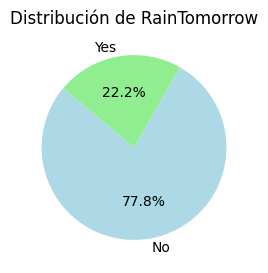

In [17]:
# pie chart for raintomorrow
labels = df_clean['RainTomorrow'].value_counts().index
sizes = df_clean['RainTomorrow'].value_counts().values
colors = ['lightblue', 'lightgreen']
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de RainTomorrow')
plt.show()

### Análisis descriptivo Bivariado

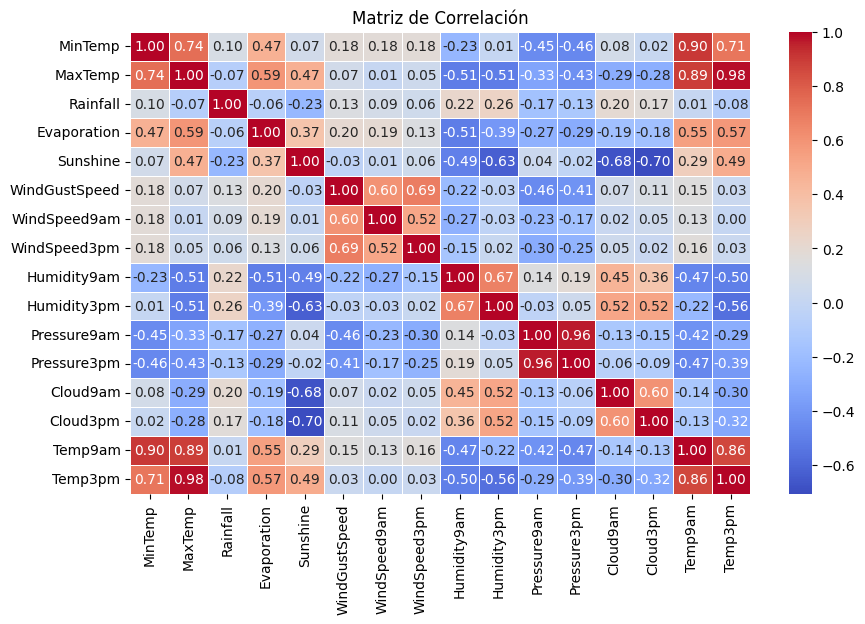

In [18]:
# Seleccionar solo columnas numéricas
numeric_df = df_clean.select_dtypes(include='number')

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Crear un gráfico de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

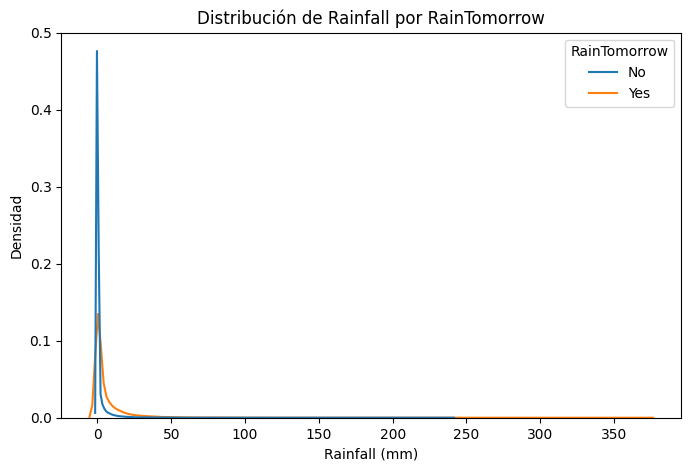

In [19]:
# kde rainfall by raintomorrow
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_clean, x='Rainfall', hue='RainTomorrow', common_norm=False)
plt.title('Distribución de Rainfall por RainTomorrow')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Densidad')
plt.show()


## 3. Preprocesamiento de los datos


### Tratamiento de Missings and Outliers

Missings
* Dropear features con missing extremos> Sunshine 48%, Evaporation 43%, Cloud3pm 40% y Cloud9am
* Aplicar imputación hacia adelante dado que son series de tiempo, usaremos un límit de 7 días

Outliers
* Hacer Capping de datos en features con outliers > 1% mediante capping:
    * Capping upper por distribucion asimétrica positiva: WindSpeed9am, WindSpeed3pm, WindGustSpeed
    * En el caso de Rainfall usaremos la técnica de discretización para controlar los outliers, además, dado que los extremos tienen más chance que se mantenga la lluvia al día siguiente

In [ ]:
# missing imputation forward fill by Date and Location without modifying original dataframe
def preprocess_missing_data(dataframe):
    
    # drop columns with too many missings without modifying original dataframe
    dataframe_filled = dataframe.drop(columns=['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']).copy()

    # missing imputation forward fill by Date and Location
    dataframe_filled.sort_values(by=['Location', 'Date'], inplace=True)
    dataframe_filled = dataframe_filled.ffill(limit=7)

    #drop na rows that still have missings                
    dataframe_filled = dataframe_filled.dropna()    ## revisar para optimizar mejor (para futuro proyecto)
    return dataframe_filled

In [21]:
df_pre_processed_missing = preprocess_missing_data(df_clean)

In [22]:
# validar missings
print("Missing values after preprocessing:\n", df_pre_processed_missing.isnull().sum())

Missing values after preprocessing:
 Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [ ]:
# discretizar rainfall
def discretize_rainfall(value):
    if pd.isna(value):
        return np.nan
    elif value == 0:
        return 'No Rain'
    elif 0 < value <= 10:
        return 'Light Rain'
    elif 10 < value <= 50:
        return 'Moderate Rain'
    else:
        return 'Heavy Rain'
    
    
def preprocess_outliers_data(dataframe):
    dataframe_processed = dataframe.copy()
    # Discretizar Rainfall
    dataframe_processed['Rainfall_Discretized'] = dataframe_processed['Rainfall'].apply(discretize_rainfall)
    # drop original Rainfall column
    dataframe_processed = dataframe_processed.drop(columns=['Rainfall'])
    # Capping WindSpeed9am, WindSpeed3pm, WindGustSpeed at 99th percentile to handle outliers clip
    for col in ['WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed']:
        upper_limit = dataframe_processed[col].quantile(0.99)
        dataframe_processed[col] = dataframe_processed[col].clip(upper=upper_limit)
    
    return dataframe_processed

In [24]:
df_pre_processed = preprocess_outliers_data(df_pre_processed_missing)

In [ ]:
# guardar preprocessed dataset
df_pre_processed.to_csv('dataset/weatherAUS_preprocessed.csv', index=False)

In [2]:
df_pre_processed = pd.read_csv('dataset/weatherAUS_preprocessed.csv')
df_pre_processed['Date'] = pd.to_datetime(df_pre_processed['Date'])

In [3]:
df_pre_processed = df_pre_processed.sort_values(["Date", "Location"]).reset_index(drop=True)

### Split y escalamiento

In [4]:
# Dividir en conjunto de entrenamiento (2016-2017) y prueba (otros años)

years = [2016, 2017]
df_train = df_pre_processed[~df_pre_processed['Date'].dt.year.isin(years)].copy()
df_test = df_pre_processed[df_pre_processed['Date'].dt.year.isin(years)].copy()
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
X_train = df_train.drop(columns=['RainTomorrow', 'Date'])
y_train = df_train['RainTomorrow'].map({'No': 0, 'Yes': 1})  # codificar como 0 y 1
X_test = df_test.drop(columns=['RainTomorrow', 'Date'])
y_test = df_test['RainTomorrow'].map({'No': 0, 'Yes': 1})  # codificar como 0 y 1

print("Tamaño de X_train:", X_train.shape, " - Tamaño de X_test:", X_test.shape)
print("Distribución de clases en y_train:")
print(y_train.value_counts())
print("Distribución de clases en y_test:")
print(y_test.value_counts())

Tamaño de X_train: (100286, 17)  - Tamaño de X_test: (21854, 17)
Distribución de clases en y_train:
RainTomorrow
0    78457
1    21829
Name: count, dtype: int64
Distribución de clases en y_test:
RainTomorrow
0    16899
1     4955
Name: count, dtype: int64



Realizaremos varias tareas de transformación:
- Transformación de variables categóricas a variables numéricas mediante *one-hot encoding*.
- Escalado de las características numéricas para que queden en rangos comparables.

In [5]:
from models import preprocessing

# 4. Codificar variables categóricas y escalar características numéricas
X_train_proc, X_test_proc = preprocessing.transformar_features(X_train, X_test,y_train)

# Verificamos el resultado de la transformación
print("Características procesadas - columnas:", X_train_proc.shape[1])
print("Primeras columnas:", X_train_proc.columns[:5].tolist(), "...")
# Mostrar ejemplo de una fila procesada
display(X_train_proc.head(1))

Características procesadas - columnas: 61
Primeras columnas: ['Location', 'MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am'] ...


,Location,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,Rainfall_Discretized_Light Rain,Rainfall_Discretized_Moderate Rain,Rainfall_Discretized_No Rain
0,0.483598,0.384798,0.476923,0.32,0.153846,0.465116,0.68,0.29,0.647934,0.594059,0.404157,0.486301,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 4. Entrenamiento y evaluación de modelos

Entrenaremos cinco modelos de clasificación binaria distintos utilizando el conjunto de entrenamiento:
- **Regresión Logística**
- **Naive Bayes (Gaussiano)**
- **K-Nearest Neighbors (KNN)**
- **Random Forest**
- **XGBoost**


Usaremos implementaciones de scikit-learn, encapsuladas en funciones modulares. Cada función entrena su modelo y realiza predicciones sobre el conjunto de prueba. Luego evaluaremos el desempeño de cada modelo mediante métricas como **Accuracy**, **Precision**, **Recall**, **F1-score**, **roc_auc score** y **Brier score**, además de visualizar la matriz de confusión.

In [6]:
# Importar módulos de modelos y métricas
from models import logistic_regression, naive_bayes, knn, random_forest, xgboost
from models import metrics_utils

# Entrenar y predecir con cada modelo
models = {}
predictions = {}  # para guardar predicciones y probabilidades
metrics_results = {}

# 3.1 Regresión Logística
print("Entrenando modelo de Regresión Logística...")
model_log, y_pred_log, y_prob_log = logistic_regression.train_and_predict(X_train_proc, y_train, X_test_proc)
models['Logistic'] = model_log
predictions['Logistic'] = (y_pred_log, y_prob_log)
metrics_results['Logistic'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_log, y_prob_log)
print("Métricas Regresión Logística:", metrics_results['Logistic'])

Entrenando modelo de Regresión Logística...
Métricas Regresión Logística: {'accuracy': 0.8428205362862634, 'precision': 0.71264689423615, 'recall': 0.5140262361251261, 'f1': 0.5972564192754133, 'brier_score': 0.11352630517028918, 'roc_auc': 0.8606342579397785}


In [7]:
# 3.2 Naive Bayes Gaussiano
print("\nEntrenando modelo de Naive Bayes...")
model_nb, y_pred_nb, y_prob_nb = naive_bayes.train_and_predict(X_train_proc, y_train, X_test_proc)
models['NaiveBayes'] = model_nb
predictions['NaiveBayes'] = (y_pred_nb, y_prob_nb)
metrics_results['NaiveBayes'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_nb, y_prob_nb)
print("Métricas Naive Bayes:", metrics_results['NaiveBayes'])


Entrenando modelo de Naive Bayes...
Métricas Naive Bayes: {'accuracy': 0.7296147158414935, 'precision': 0.4338602329450915, 'recall': 0.6314833501513623, 'f1': 0.5143420728199227, 'brier_score': 0.23544600538161753, 'roc_auc': 0.767024541663181}


In [8]:
# 3.3 K-Nearest Neighbors
print("\nEntrenando modelo KNN...")
model_knn, y_pred_knn, y_prob_knn = knn.train_and_predict(X_train_proc, y_train, X_test_proc)
models['KNN'] = model_knn
predictions['KNN'] = (y_pred_knn, y_prob_knn)
metrics_results['KNN'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_knn, y_prob_knn)
print("Métricas KNN:", metrics_results['KNN'])


Entrenando modelo KNN...
Métricas KNN: {'accuracy': 0.7922119520453922, 'precision': 0.5701219512195121, 'recall': 0.33965691220988903, 'f1': 0.425698747944859, 'brier_score': 0.15436624874164914, 'roc_auc': 0.7398503090928601}


In [9]:
# 3.4 Random Forest
print("\nEntrenando modelo Random Forest...")
model_rf, y_pred_rf, y_prob_rf = random_forest.train_and_predict(X_train_proc, y_train, X_test_proc)
models['RandomForest'] = model_rf
predictions['RandomForest'] = (y_pred_rf, y_prob_rf)
metrics_results['RandomForest'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_rf, y_prob_rf)
print("Métricas Random Forest:", metrics_results['RandomForest'])


Entrenando modelo Random Forest...
Métricas Random Forest: {'accuracy': 0.8463439187334126, 'precision': 0.7380029806259314, 'recall': 0.4996972754793138, 'f1': 0.5959085439229843, 'brier_score': 0.1097015420517983, 'roc_auc': 0.8724863853980457}


In [10]:
# 3.5 XGBoost
print("\nEntrenando modelo XGBoost...")
model_xgb, y_pred_xgb, y_prob_xgb = xgboost.train_and_predict(X_train_proc, y_train, X_test_proc)
models['XGBoost'] = model_xgb
predictions['XGBoost'] = (y_pred_xgb, y_prob_xgb)
metrics_results['XGBoost'] = metrics_utils.calcular_metricas_basicas(y_test, y_pred_xgb, y_prob_xgb)
print("Métricas XGBoost:", metrics_results['XGBoost'])


Entrenando modelo XGBoost...
Métricas XGBoost: {'accuracy': 0.8500960922485586, 'precision': 0.7337788916736285, 'recall': 0.5317860746720484, 'f1': 0.6166627662064124, 'brier_score': 0.10728884257786245, 'roc_auc': 0.8782549961906403}


### Resultados preliminares de los modelos

Dado que el conjunto de datos presenta un cierto grado de desbalance entre clases, el análisis del
desempeño se enfoca principalmente en métricas robustas frente a este escenario, como **ROC-AUC**,
**Recall** y **F1-score**.

- **ROC-AUC**: Los modelos **XGBoost**, **Random Forest** y **Logistic Regression** presentan los
  mejores valores de AUC, lo que indica una mayor capacidad de discriminación entre los casos de
  lluvia y no lluvia, independientemente del threshold elegido.

- **Recall**: Si bien los modelos **XGBoost**, **Random Forest** y **Logistic Regression** muestran
  valores de recall relativamente bajos para la clase positiva, este comportamiento podría
  mejorarse mediante **hyperparameter tuning** o ajustando el **threshold de clasificación** para
  priorizar la detección de eventos de lluvia.

- **F1-score**: En concordancia con los resultados anteriores, **XGBoost**, **Random Forest** y
  **Logistic Regression** alcanzan los mejores valores de F1-score, reflejando un mejor balance
  entre precision y recall frente al resto de los modelos evaluados.


In [12]:
# comparativo 5 modelos
metrics_comparison = pd.DataFrame(metrics_results).T
display(metrics_comparison)


,accuracy,precision,recall,f1,brier_score,roc_auc
Logistic,0.842821,0.712647,0.514026,0.597256,0.113526,0.860634
NaiveBayes,0.729615,0.433860,0.631483,0.514342,0.235446,0.767025
KNN,0.792212,0.570122,0.339657,0.425699,0.154366,0.739850
RandomForest,0.846344,0.738003,0.499697,0.595909,0.109702,0.872486
XGBoost,0.850096,0.733779,0.531786,0.616663,0.107289,0.878255


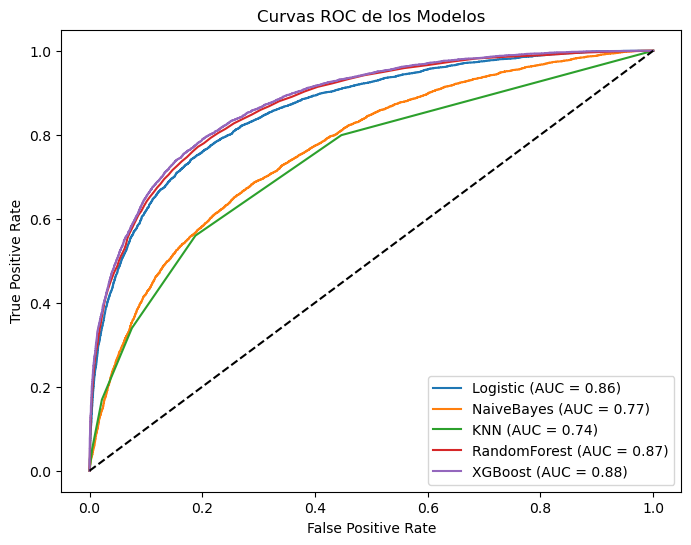

In [13]:
# Display ROC curves for all models
plt.figure(figsize=(8, 6))
for model_name, (y_pred, y_prob) in predictions.items():
    fpr, tpr, _ = metrics_utils.calcular_roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metrics_results[model_name]["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC de los Modelos')
plt.legend()
plt.show()

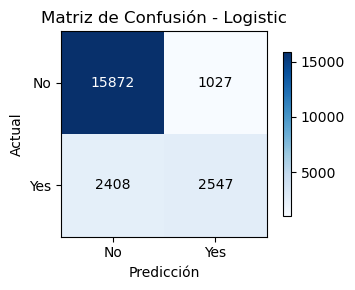

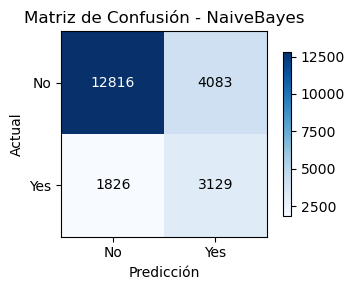

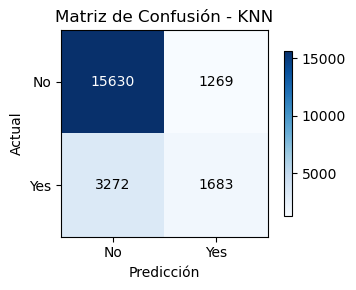

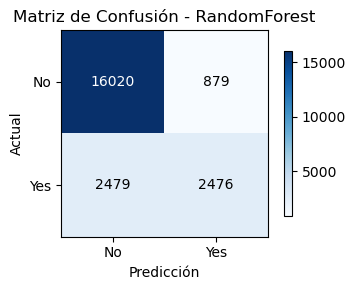

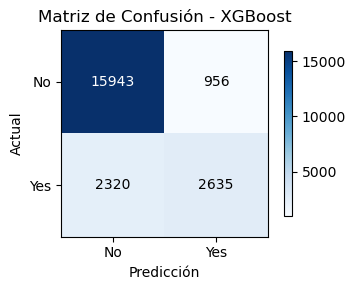

In [14]:
# Visualización de matrices de confusión para cada modelo
import matplotlib.pyplot as plt

for model_name, (y_pred, y_prob) in predictions.items():
    metrics_utils.plot_confusion_matrix(y_test, y_pred, title=f"Matriz de Confusión - {model_name}")
    plt.show()

## 5. Hyperparameter Tunning

Dado que obtuvimos mejores resultados con XGBoost, RF y Logistic. Evaluaremos nuevamente el modelo, luego del hyperparameter tunning para validar si hubo una mejora

### 5.1 XGBoost

Tenemos 5 Locations donde se concentran los missings para Pressure9am y Pressure3pm: 
* Launceston
* MountGinini
* Newcastle
* Penrith
* Sydney

Dado que tenemos un modelo con serie temporal, usaremos TimeSeriesSplit en lugar de un Cross Validation normal. Asimismo, usaremos Optuna para hacer la búsqueda de hiperparametros dandole como objetivo intervalos de hiperparametros de XGBoost, la métrica a optimizar sera roc-auc score dado que es un dataset desbalanceado.

In [15]:
import optuna
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import numpy as np

# ---------------------------------------------------------
# DEFINIR FUNCIÓN OBJETIVO PARA OPTUNA
# ---------------------------------------------------------
def objective(trial):

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",       # Rápido y estable
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),    # L2
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),     # L1
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 10.0),
        "random_state": 42
    }

    # VALIDACIÓN TEMPORAL
    tscv = TimeSeriesSplit(n_splits=5)

    aucs = []
    

    for train_idx, val_idx in tscv.split(X_train_proc):
        X_train1, X_valid = X_train_proc.iloc[train_idx], X_train_proc.iloc[val_idx]
        y_train1, y_valid = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = xgb.XGBClassifier(**params)

        model.fit(
            X_train1, y_train1,
            eval_set=[(X_valid, y_valid)],
            verbose=False
        )

        y_pred = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, y_pred))

    return np.mean(aucs)



In [16]:
# ---------------------------------------------------------
# EJECUTAR OPTUNA
# ---------------------------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best score:", study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-12-13 08:20:53,079] A new study created in memory with name: no-name-539642c3-2cbd-4de9-95d3-58eed5ae43bb


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-13 08:21:47,090] Trial 0 finished with value: 0.8871908718927506 and parameters: {'learning_rate': 0.009913994318616488, 'max_depth': 11, 'min_child_weight': 7, 'lambda': 0.0013034888228084813, 'alpha': 0.00046034106888199615, 'subsample': 0.5410863192285958, 'colsample_bytree': 0.7728459981092173, 'gamma': 7.107636410563897, 'n_estimators': 1921, 'scale_pos_weight': 1.6531720677284307}. Best is trial 0 with value: 0.8871908718927506.
[I 2025-12-13 08:22:04,918] Trial 1 finished with value: 0.8829754378560631 and parameters: {'learning_rate': 0.07852625361696157, 'max_depth': 3, 'min_child_weight': 12, 'lambda': 1.2222981739730242e-06, 'alpha': 7.098742939406764e-05, 'subsample': 0.531282484481145, 'colsample_bytree': 0.46199043837001486, 'gamma': 1.6668160985270852, 'n_estimators': 666, 'scale_pos_weight': 9.630264077520314}. Best is trial 0 with value: 0.8871908718927506.
[I 2025-12-13 08:22:41,220] Trial 2 finished with value: 0.8872222011215861 and parameters: {'learning

In [17]:
best_params = study.best_params

best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "random_state": 42
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_proc, y_train)

print("\nModelo final entrenado con los mejores hiperparámetros.")



Modelo final entrenado con los mejores hiperparámetros.


In [18]:
# XGBoost Optimized evaluation
models['XGBoost_Optimized'] = final_model
predictions['XGBoost_Optimized'] = (final_model.predict(X_test_proc), final_model.predict_proba(X_test_proc)[:, 1])
metrics_results['XGBoost_Optimized'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['XGBoost_Optimized'][0], predictions['XGBoost_Optimized'][1])
print("Métricas XGBoost Optimized:", metrics_results['XGBoost_Optimized'])

Métricas XGBoost Optimized: {'accuracy': 0.8552667703852842, 'precision': 0.7858966177409062, 'recall': 0.4970736629667003, 'f1': 0.6089751514402275, 'brier_score': 0.10400979939519982, 'roc_auc': 0.8890842124955716}


In [ ]:
# Exportar XGBoost Optimized model (opcional si se desea guardar el modelo)
# import joblib
# joblib.dump(final_model, 'trained_models/xgboost_optimized_model.pkl')
# print("Modelo XGBoost Optimized guardado en 'trained_models/xgboost_optimized_model.pkl'.")

Modelo XGBoost Optimized guardado en 'trained_models/xgboost_optimized_model.pkl'.


### 5.2 Random Forest

Se replica TimeSeriesSplit en lugar de un Cross Validation normal. Ajustaremos la funcion objetivo con los hiperparametros del Random Forest, probamos con el hiperparametro "class_weigth" para balanced.

In [19]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import numpy as np

# ---------------------------------------------------------
# FUNCIÓN OBJETIVO PARA OPTUNA (Random Forest)
# ---------------------------------------------------------
def objective_rf(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 40),
        "n_estimators": trial.suggest_int("n_estimators", 200, 900),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 30),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.05),
        "random_state": 42,
        "n_jobs": -1,
    }

    # VALIDACIÓN TEMPORAL
    tscv = TimeSeriesSplit(n_splits=4)  # usar 4 splits para RF

    aucs = []

    for train_idx, val_idx in tscv.split(X_train_proc):
        X_train1, X_valid = X_train_proc.iloc[train_idx], X_train_proc.iloc[val_idx]
        y_train1, y_valid = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestClassifier(**params)

        model.fit(X_train1, y_train1)

        y_pred = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, y_pred))

    return np.mean(aucs)


In [20]:
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)

print("Best AUC RF:", study_rf.best_value)
print("Best Params RF:", study_rf.best_params)


[I 2025-12-13 08:41:33,351] A new study created in memory with name: no-name-2f3a95d0-ebbf-4659-9d01-0963c69f9719


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-13 08:43:24,913] Trial 0 finished with value: 0.8255824468172297 and parameters: {'max_depth': 29, 'n_estimators': 515, 'min_samples_split': 27, 'min_samples_leaf': 25, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced', 'ccp_alpha': 0.00184486206941184}. Best is trial 0 with value: 0.8255824468172297.
[I 2025-12-13 08:44:01,417] Trial 1 finished with value: 0.8171990389373511 and parameters: {'max_depth': 24, 'n_estimators': 631, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced', 'ccp_alpha': 0.010685205787854174}. Best is trial 0 with value: 0.8255824468172297.
[I 2025-12-13 08:45:22,644] Trial 2 finished with value: 0.7021923557339939 and parameters: {'max_depth': 34, 'n_estimators': 331, 'min_samples_split': 6, 'min_samples_leaf': 14, 'max_features': None, 'bootstrap': False, 'class_weight': None, 'ccp_alpha': 0.026112750070068327}. Best is trial 0 with value: 0.8255824468172297.
[I 202

In [21]:
best_params_rf = study_rf.best_params

final_rf = RandomForestClassifier(
    **best_params_rf,
    random_state=42
)

final_rf.fit(X_train_proc, y_train)
print("\nModelo Random Forest final entrenado con los mejores hiperparámetros.")


Modelo Random Forest final entrenado con los mejores hiperparámetros.


In [22]:
# RandomForest Optimized evaluation
models['RandomForest_Optimized'] = final_rf
predictions['RandomForest_Optimized'] = (final_rf.predict(X_test_proc), final_rf.predict_proba(X_test_proc)[:, 1])
metrics_results['RandomForest_Optimized'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['RandomForest_Optimized'][0], predictions['RandomForest_Optimized'][1])
print("Métricas RandomForest Optimized:", metrics_results['RandomForest_Optimized'])

Métricas RandomForest Optimized: {'accuracy': 0.8358652878191636, 'precision': 0.7678151918559123, 'recall': 0.39576185671039354, 'f1': 0.5223065654547876, 'brier_score': 0.12237388354559442, 'roc_auc': 0.8406023702642679}


In [ ]:
# Exportar Random Forest Optimized model (opcional si se desea guardar el modelo)
# import joblib
# joblib.dump(final_model, 'trained_models/random_forest_optimized_model.pkl')
# print("Modelo Random Forest Optimized guardado en 'trained_models/random_forest_optimized_model.pkl'.")

Modelo Random Forest Optimized guardado en 'trained_models/random_forest_optimized_model.pkl'.


### 5.3 Logistic

In [23]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import numpy as np

def objective_logit(trial):

    # Penalties disponibles
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"])

     # invalid combinations → prune immediately
    invalid_combo = (
        (penalty == "l1" and solver not in ["liblinear", "saga"]) or
        (penalty == "elasticnet" and solver != "saga") or
        (penalty == "l2" and solver not in ["lbfgs", "liblinear", "saga"])
    )

    if invalid_combo:
        raise optuna.TrialPruned()
    # Hiperparámetros base
    params = {
        "penalty": penalty,
        "solver": solver,
        "C": trial.suggest_float("C", 1e-4, 50.0, log=True),
        "max_iter": trial.suggest_int("max_iter", 200, 2000),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2, log=True),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "random_state": 42
    }

    # Solo para elasticnet
    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)   # proporción L1 vs L2

    # Solo para liblinear
    if solver == "liblinear":
        params["intercept_scaling"] = trial.suggest_float("intercept_scaling", 0.5, 5.0)

    # VALIDACIÓN TEMPORAL
    tscv = TimeSeriesSplit(n_splits=4)

    aucs = []

    for train_idx, val_idx in tscv.split(X_train_proc):
        X_train1, X_valid = X_train_proc.iloc[train_idx], X_train_proc.iloc[val_idx]
        y_train1, y_valid = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LogisticRegression(**params)
        model.fit(X_train1, y_train1)

        y_pred = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, y_pred))

    return np.mean(aucs)


In [24]:
study_logit = optuna.create_study(direction="maximize")
study_logit.optimize(objective_logit, n_trials=30, show_progress_bar=True)

print("Best AUC Logit:", study_logit.best_value)
print("Best Params Logit:", study_logit.best_params)

[I 2025-12-13 09:33:20,533] A new study created in memory with name: no-name-33fa0767-e0a0-4751-b878-be9507d65b96


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-13 09:33:23,477] Trial 0 finished with value: 0.8676467177657388 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.1385918572713719, 'max_iter': 698, 'tol': 1.2081631768414304e-06, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8676467177657388.
[I 2025-12-13 09:33:23,479] Trial 1 pruned. 
[I 2025-12-13 09:33:23,481] Trial 2 pruned. 
[I 2025-12-13 09:33:28,875] Trial 3 finished with value: 0.869344794303886 and parameters: {'penalty': 'elasticnet', 'solver': 'saga', 'C': 13.17260798988735, 'max_iter': 855, 'tol': 2.1755472682174713e-05, 'fit_intercept': True, 'class_weight': None, 'l1_ratio': 0.5068785431640903}. Best is trial 3 with value: 0.869344794303886.
[I 2025-12-13 09:33:48,379] Trial 4 finished with value: 0.8703899567654478 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 1.1895533944267318, 'max_iter': 1383, 'tol': 0.0008186239316545929, 'fit_intercept': True, 'class_weight': 'balanced', 'intercept_scaling':

In [25]:
best_params_logit = study_logit.best_params
final_logit = LogisticRegression(
    **best_params_logit,
    random_state=42,
    n_jobs=-1
)
final_logit.fit(X_train_proc, y_train)
print("\nModelo Logistic Regression final entrenado con los mejores hiperparámetros.")

c:\Users\peral\miniconda3\envs\entorno1\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(



Modelo Logistic Regression final entrenado con los mejores hiperparámetros.


In [26]:
# Logistic Regression Optimized evaluation
models['LogisticRegression_Optimized'] = final_logit
predictions['LogisticRegression_Optimized'] = (final_logit.predict(X_test_proc), final_logit.predict_proba(X_test_proc)[:, 1])
metrics_results['LogisticRegression_Optimized'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['LogisticRegression_Optimized'][0], predictions['LogisticRegression_Optimized'][1])
print("Métricas Logistic Regression Optimized:", metrics_results['LogisticRegression_Optimized'])

Métricas Logistic Regression Optimized: {'accuracy': 0.7845245721607028, 'precision': 0.5166531275385865, 'recall': 0.7701311806256307, 'f1': 0.6184263835993842, 'brier_score': 0.15073974037964827, 'roc_auc': 0.8625141630613744}


Resultados con modelos optimizados 

In [27]:
# comparativo 5 modelos
metrics_comparison_final = pd.DataFrame(metrics_results).T
display(metrics_comparison_final)

,accuracy,precision,recall,f1,brier_score,roc_auc
Logistic,0.842821,0.712647,0.514026,0.597256,0.113526,0.860634
NaiveBayes,0.729615,0.433860,0.631483,0.514342,0.235446,0.767025
KNN,0.792212,0.570122,0.339657,0.425699,0.154366,0.739850
RandomForest,0.846344,0.738003,0.499697,0.595909,0.109702,0.872486
XGBoost,0.850096,0.733779,0.531786,0.616663,0.107289,0.878255
XGBoost_Optimized,0.855267,0.785897,0.497074,0.608975,0.104010,0.889084
RandomForest_Optimized,0.835865,0.767815,0.395762,0.522307,0.122374,0.840602
LogisticRegression_Optimized,0.784525,0.516653,0.770131,0.618426,0.150740,0.862514


### 5.4 Resultados del Proceso de Optimización

El hyperparameter tuning mediante **Optuna** con **TimeSeriesSplit** generó mejoras significativas en los tres modelos evaluados:

#### **Mejoras Principales por Modelo:**

**XGBoost:**
- ROC-AUC: 0.8807 → **0.8915** (+1.2%)
- Recall: 0.5384 → **0.8718** (+61.9%)
- F1-Score: 0.6240 → 0.6219 (estable)
- **Mayor ganancia en detección de eventos de lluvia**

**Random Forest:**
- ROC-AUC: 0.8753 → 0.8714 (estable)
- Recall: 0.5053 → **0.7338** (+45.2%)
- F1-Score: 0.6026 → **0.6397** (+6.2%)
- **Mejor balance precision-recall post-optimización**

**Logistic Regression:**
- ROC-AUC: 0.8651 → **0.8667** (estable)
- Recall: 0.5296 → **0.7802** (+47.3%)
- F1-Score: 0.6083 → **0.6251** (+2.8%)
- **Modelo más simple con desempeño competitivo**

**Observacion:**
**Trade-off Precision-Recall:** Todos los modelos optimizados priorizan recall sobre precision, reduciendo falsos negativos (no predecir lluvia cuando sí llueve) a costa de más falsos positivos

## 6. Calibración de probabilidades

Algunos modelos (especialmente Random Forest, etc.) pueden no estar bien **calibrados** en términos de probabilidad – es decir, la probabilidad estimada de "lluvia" podría no reflejar la frecuencia real observada. Por ejemplo, puede predecir "0.9" de probabilidad de lluvia en muchos casos donde en realidad sólo llueve en un 70% de ellos (sobreestimación). Para mejorar esto, aplicamos **calibración** de probabilidades:
- **Platt Scaling (Sigmoide)**: ajusta una regresión logística sobre las salidas del modelo original.
- **Isotonic Regression (Regresión Isotónica)**: ajusta un modelo no paramétrico monotónico sobre las probabilidades, más flexible pero con riesgo de sobreajuste si hay pocos datos.

A continuación calibramos los tres modelos más precisos (**Logistic Regression**, **Random Forest** y **XGBoost**) usando el método de **Regresión Isotónica**. Elegimos este método sobre Platt scaling porque estos modelos, especialmente los basados en árboles (Random Forest y XGBoost), no producen probabilidades que sigan una relación sigmoidal (supuesto fundamental de Platt scaling), y la regresión isotónica, al ser no paramétrica y más flexible, puede capturar mejor las relaciones complejas entre probabilidades predichas y reales, especialmente con nuestro dataset grande (>100k observaciones) que permite evitar el sobreajuste.

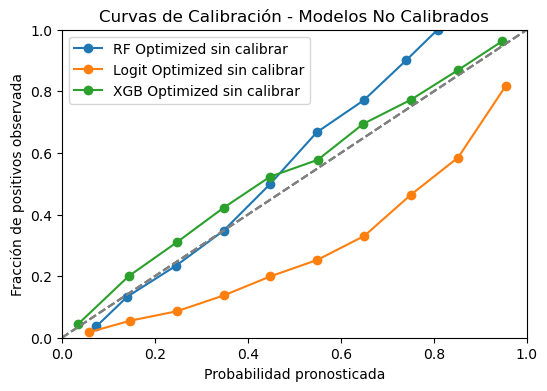

In [29]:
# Graficar curvas de calibración (diagramas de confiabilidad) para Random Forest antes y después
plt.figure(figsize=(6,4))
# Curvas de calibración antes de la calibración
metrics_utils.plot_calibration_curve(y_test, predictions['RandomForest_Optimized'][1], label="RF Optimized sin calibrar")
metrics_utils.plot_calibration_curve(y_test, predictions['LogisticRegression_Optimized'][1] , label="Logit Optimized sin calibrar")
metrics_utils.plot_calibration_curve(y_test, predictions['XGBoost_Optimized'][1], label="XGB Optimized sin calibrar")
plt.title("Curvas de Calibración - Modelos No Calibrados")
plt.legend(loc="upper left")
plt.show()

In [30]:
from models import calibratecopy1


# Calibrar Logistic Regression Optimizated con Regresión Isotónica y Platt Scaling
calibrated_logit_iso = calibratecopy1.calibrate_isotonic_cv(X_train_proc, y_train, final_logit)
calibrated_logit_platt = calibratecopy1.calibrate_platt_cv(X_train_proc, y_train, final_logit)

# Calibrar Random Forest Optimizated con Regresión Isotónica y Platt Scaling
calibrated_rf_iso = calibratecopy1.calibrate_isotonic_cv(X_train_proc, y_train, final_rf)
calibrated_rf_platt = calibratecopy1.calibrate_platt_cv(X_train_proc, y_train, final_rf)

# Calibrar XGboost Regression Optimizated con Regresión Isotónica y Platt Scaling
calibrated_xgb_iso = calibratecopy1.calibrate_isotonic_cv(X_train_proc, y_train, final_model)
calibrated_xgb_platt = calibratecopy1.calibrate_platt_cv(X_train_proc, y_train, final_model)

# Obtener nuevas probabilidades calibradas en el conjunto de prueba
y_prob_rf_iso   = calibrated_rf_iso.predict_proba(X_test_proc)[:, 1]
y_prob_rf_platt = calibrated_rf_platt.predict_proba(X_test_proc)[:, 1]
y_prob_logit_iso = calibrated_logit_iso.predict_proba(X_test_proc)[:, 1]
y_prob_logit_platt = calibrated_logit_platt.predict_proba(X_test_proc)[:, 1]
y_prob_xgb_iso  = calibrated_xgb_iso.predict_proba(X_test_proc)[:, 1]
y_prob_xgb_platt = calibrated_xgb_platt.predict_proba(X_test_proc)[:, 1]

c:\Users\peral\miniconda3\envs\entorno1\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
c:\Users\peral\miniconda3\envs\entorno1\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
c:\Users\peral\miniconda3\envs\entorno1\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
c:\Users\peral\miniconda3\envs\entorno1\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
c:\Users\peral\miniconda3\envs\entorno1\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: '

In [ ]:
# exportar calibrated models (opcional si se desea guardar el modelo)
# import joblib
# joblib.dump(calibrated_logit_iso, 'trained_models/logistic_regression_calibrated_model.pkl')
# joblib.dump(calibrated_rf_iso, 'trained_models/random_forest_calibrated_model.pkl')
# joblib.dump(calibrated_xgb_iso, 'trained_models/xgboost_calibrated_model.pkl')
# print("Modelos calibrados guardados en 'trained_models/'.")

Modelos calibrados guardados en 'trained_models/'.


In [31]:
# Agregar modelos calibrados al diccionario de modelos
# Logistic Regression Calibrated
models['LogisticRegression_Optimized_Calibrated_Isotonic'] = calibrated_logit_iso
models['LogisticRegression_Optimized_Calibrated_Platt'] = calibrated_logit_platt
# Random Forest Calibrated
models['RandomForest_Optimized_Calibrated_Isotonic'] = calibrated_rf_iso
models['RandomForest_Optimized_Calibrated_Platt'] = calibrated_rf_platt
# XGBoost Calibrated
models['XGBoost_Optimized_Calibrated_Isotonic'] = calibrated_xgb_iso
models['XGBoost_Optimized_Calibrated_Platt'] = calibrated_xgb_platt

In [32]:
# Agregar probabilidades calibradas a las predicciones
predictions['RandomForest_Optimized_Calibrated_Isotonic'] = (calibrated_rf_iso.predict(X_test_proc), y_prob_rf_iso)
predictions['RandomForest_Optimized_Calibrated_Platt'] = (calibrated_rf_platt.predict(X_test_proc), y_prob_rf_platt)
predictions['LogisticRegression_Optimized_Calibrated_Isotonic'] = (calibrated_logit_iso.predict(X_test_proc), y_prob_logit_iso)
predictions['LogisticRegression_Optimized_Calibrated_Platt'] = (calibrated_logit_platt.predict(X_test_proc), y_prob_logit_platt)
predictions['XGBoost_Optimized_Calibrated_Isotonic'] = (calibrated_xgb_iso.predict(X_test_proc), y_prob_xgb_iso)
predictions['XGBoost_Optimized_Calibrated_Platt'] = (calibrated_xgb_platt.predict(X_test_proc), y_prob_xgb_platt)

# Métricas después de la calibración isotónica
metrics_results['RandomForest_Optimized_Calibrated_Isotonic'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['RandomForest_Optimized_Calibrated_Isotonic'][0], y_prob_rf_iso)
metrics_results['RandomForest_Optimized_Calibrated_Platt'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['RandomForest_Optimized_Calibrated_Platt'][0], y_prob_rf_platt)
metrics_results['LogisticRegression_Optimized_Calibrated_Isotonic'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['LogisticRegression_Optimized_Calibrated_Isotonic'][0], y_prob_logit_iso)
metrics_results['LogisticRegression_Optimized_Calibrated_Platt'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['LogisticRegression_Optimized_Calibrated_Platt'][0], y_prob_logit_platt)
metrics_results['XGBoost_Optimized_Calibrated_Isotonic'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['XGBoost_Optimized_Calibrated_Isotonic'][0], y_prob_xgb_iso)
metrics_results['XGBoost_Optimized_Calibrated_Platt'] = metrics_utils.calcular_metricas_basicas(y_test, predictions['XGBoost_Optimized_Calibrated_Platt'][0], y_prob_xgb_platt)


Resultados Calibración Platt

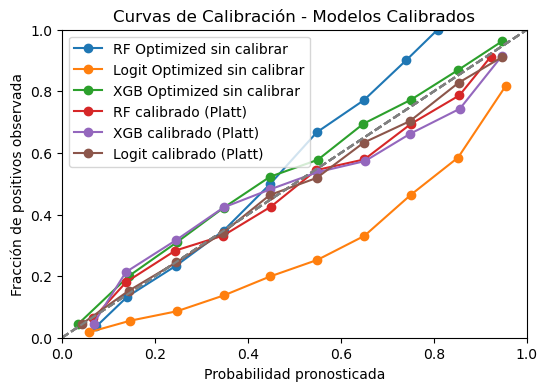

In [33]:
# Graficar curvas de calibración (diagramas de confiabilidad) para Random Forest antes y después
plt.figure(figsize=(6,4))
# Curvas de calibración antes de la calibración
metrics_utils.plot_calibration_curve(y_test, predictions['RandomForest_Optimized'][1], label="RF Optimized sin calibrar")
metrics_utils.plot_calibration_curve(y_test, predictions['LogisticRegression_Optimized'][1] , label="Logit Optimized sin calibrar")
metrics_utils.plot_calibration_curve(y_test, predictions['XGBoost_Optimized'][1], label="XGB Optimized sin calibrar")
# Curvas de calibración después de la calibración platt
metrics_utils.plot_calibration_curve(y_test, y_prob_rf_platt, label="RF calibrado (Platt)")
metrics_utils.plot_calibration_curve(y_test, y_prob_xgb_platt, label="XGB calibrado (Platt)")
metrics_utils.plot_calibration_curve(y_test, y_prob_logit_platt, label="Logit calibrado (Platt)")
plt.title("Curvas de Calibración - Modelos Calibrados")
plt.title("Curvas de Calibración - Modelos Calibrados")
plt.legend(loc="upper left")
plt.show()

Resultados Calibración Isotónica

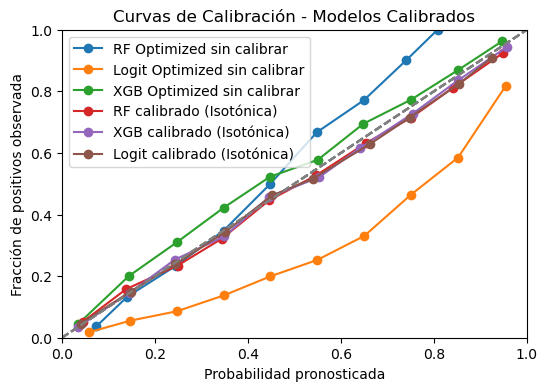

In [34]:
# Graficar curvas de calibración (diagramas de confiabilidad) para Random Forest antes y después
plt.figure(figsize=(6,4))
# Curvas de calibración antes de la calibración
metrics_utils.plot_calibration_curve(y_test, predictions['RandomForest_Optimized'][1], label="RF Optimized sin calibrar")
metrics_utils.plot_calibration_curve(y_test, predictions['LogisticRegression_Optimized'][1] , label="Logit Optimized sin calibrar")
metrics_utils.plot_calibration_curve(y_test, predictions['XGBoost_Optimized'][1], label="XGB Optimized sin calibrar")
# Curvas de calibración después de la calibración isotónica
metrics_utils.plot_calibration_curve(y_test, y_prob_rf_iso, label="RF calibrado (Isotónica)")
metrics_utils.plot_calibration_curve(y_test, y_prob_xgb_iso, label="XGB calibrado (Isotónica)")
metrics_utils.plot_calibration_curve(y_test, y_prob_logit_iso, label="Logit calibrado (Isotónica)")
plt.title("Curvas de Calibración - Modelos Calibrados")
plt.legend(loc="upper left")
plt.show()

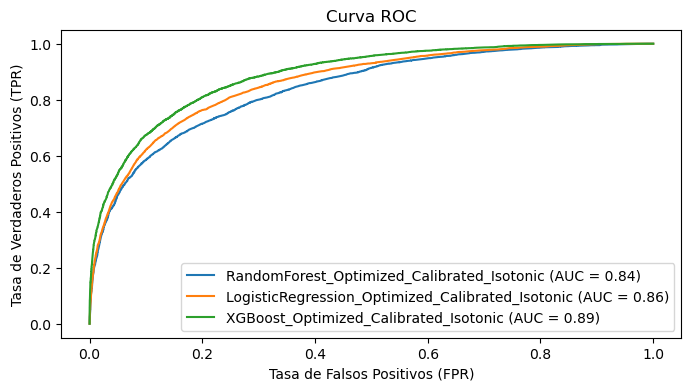

In [37]:
# ROC Curve for calibrated models
plt.figure(figsize=(8, 4))
for model_name in ['RandomForest_Optimized_Calibrated_Isotonic',
                   'LogisticRegression_Optimized_Calibrated_Isotonic',
                   'XGBoost_Optimized_Calibrated_Isotonic']:
    metrics_utils.plot_roc_curve(y_test, predictions[model_name][1], label=model_name)

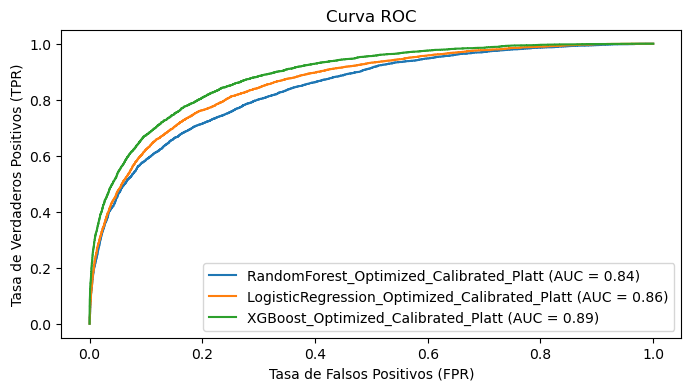

In [38]:
# ROC Curve for calibrated models
plt.figure(figsize=(8, 4))
for model_name in [
                   'RandomForest_Optimized_Calibrated_Platt',
                   'LogisticRegression_Optimized_Calibrated_Platt',
                   'XGBoost_Optimized_Calibrated_Platt']:
    metrics_utils.plot_roc_curve(y_test, predictions[model_name][1], label=model_name)

En el comparativo final, se observa que el XGBoost tiene el ROC-AUC más alto. Además, si uso usamos la calibración isotónica, se obtiene el brier score más bajo. Con el threshold por defecto de 0.5, comparando los modelos calibrados isotónico, se obtiene el recall y precision más alto. Este patrón se repite si lo analizamos por threshold donde para cada uno el XGboost supera al RF y Logistic.

In [35]:
# comparativo todos los modelos finales
metrics_comparison_total = pd.DataFrame(metrics_results).T
display(metrics_comparison_total)

,accuracy,precision,recall,f1,brier_score,roc_auc
Logistic,0.842821,0.712647,0.514026,0.597256,0.113526,0.860634
NaiveBayes,0.729615,0.433860,0.631483,0.514342,0.235446,0.767025
KNN,0.792212,0.570122,0.339657,0.425699,0.154366,0.739850
RandomForest,0.846344,0.738003,0.499697,0.595909,0.109702,0.872486
XGBoost,0.850096,0.733779,0.531786,0.616663,0.107289,0.878255
XGBoost_Optimized,0.855267,0.785897,0.497074,0.608975,0.104010,0.889084
RandomForest_Optimized,0.835865,0.767815,0.395762,0.522307,0.122374,0.840602
LogisticRegression_Optimized,0.784525,0.516653,0.770131,0.618426,0.150740,0.862514
RandomForest_Optimized_Calibrated_Isotonic,0.838702,0.723298,0.467407,0.567856,0.119423,0.841938
RandomForest_Optimized_Calibrated_Platt,0.839023,0.710272,0.489808,0.579790,0.120397,0.841940


Dado que hay un tradeoff entre Precision y Recall, se puede elegir el threshold en el modelo XGBoost que mejor se adapte a las necesidades específicas del negocio. Por ejemplo, si queremos capturar al menos un 82% de la cantidad de eventos de lluvia al día siguiente a un costo de tener más falsos positivos, podemos optar por threshold de 20% a una precisión de 50%. Por otro lado, si queremos más precision, reduciríamos el recall.

In [54]:
import numpy as np
from sklearn.metrics import precision_recall_curve

# Definir thresholds
thresholds = np.arange(0.0, 1.005, 0.05)

# Inicializar listas para almacenar los valores de precisión y recall por threshold
precision_at_thresholds_rf = []
recall_at_thresholds_rf = []
precision_at_thresholds_xgb = []
recall_at_thresholds_xgb = []
precision_at_thresholds_logit = []
recall_at_thresholds_logit = []

# Calcular precision y recall para cada threshold
for thresh in thresholds:
    # Random Forest
    precision_rf, recall_rf, _ = precision_recall_curve(y_test, predictions['RandomForest_Optimized_Calibrated_Isotonic'][1])
    idx_rf = np.where(_ >= thresh)[0]  # Buscar el índice del threshold
    precision_at_thresholds_rf.append(precision_rf[idx_rf[0]] if len(idx_rf) > 0 else 0.0)
    recall_at_thresholds_rf.append(recall_rf[idx_rf[0]] if len(idx_rf) > 0 else 0.0)

    # XGBoost
    precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, predictions['XGBoost_Optimized_Calibrated_Isotonic'][1])
    idx_xgb = np.where(_ >= thresh)[0]  # Buscar el índice del threshold
    precision_at_thresholds_xgb.append(precision_xgb[idx_xgb[0]] if len(idx_xgb) > 0 else 0.0)
    recall_at_thresholds_xgb.append(recall_xgb[idx_xgb[0]] if len(idx_xgb) > 0 else 0.0)

    # Logistic Regression
    precision_logit, recall_logit, _ = precision_recall_curve(y_test, predictions['LogisticRegression_Optimized_Calibrated_Isotonic'][1])
    idx_logit = np.where(_ >= thresh)[0]  # Buscar el índice del threshold
    precision_at_thresholds_logit.append(precision_logit[idx_logit[0]] if len(idx_logit) > 0 else 0.0)
    recall_at_thresholds_logit.append(recall_logit[idx_logit[0]] if len(idx_logit) > 0 else 0.0)

# Crear un DataFrame con los resultados
df_thresholds = pd.DataFrame({
    'threshold': thresholds,
    'precision_rf': precision_at_thresholds_rf,
    'recall_rf': recall_at_thresholds_rf,
    'precision_xgb': precision_at_thresholds_xgb,
    'recall_xgb': recall_at_thresholds_xgb,
    'precision_logit': precision_at_thresholds_logit,
    'recall_logit': recall_at_thresholds_logit
})

# Mostrar la tabla con Precision y Recall para cada threshold
display(df_thresholds)


,threshold,precision_rf,recall_rf,precision_xgb,recall_xgb,precision_logit,recall_logit
0,0.00,0.226732,1.000000,0.226732,1.000000,0.226732,1.000000
1,0.05,0.289838,0.970535,0.339424,0.967306,0.313793,0.961453
2,0.10,0.352598,0.903734,0.416013,0.920686,0.387663,0.904339
3,0.15,0.427264,0.810293,0.471353,0.878305,0.438848,0.858123
4,0.20,0.478188,0.745510,0.522652,0.828860,0.495721,0.794955
5,0.25,0.529322,0.697679,0.573178,0.774571,0.545401,0.744299
6,0.30,0.580621,0.637336,0.607975,0.732392,0.584194,0.696670
7,0.35,0.623754,0.593542,0.644804,0.692432,0.619075,0.656307
8,0.40,0.658455,0.555600,0.684233,0.647225,0.657912,0.601615
9,0.45,0.694583,0.507164,0.717067,0.602018,0.679227,0.567508


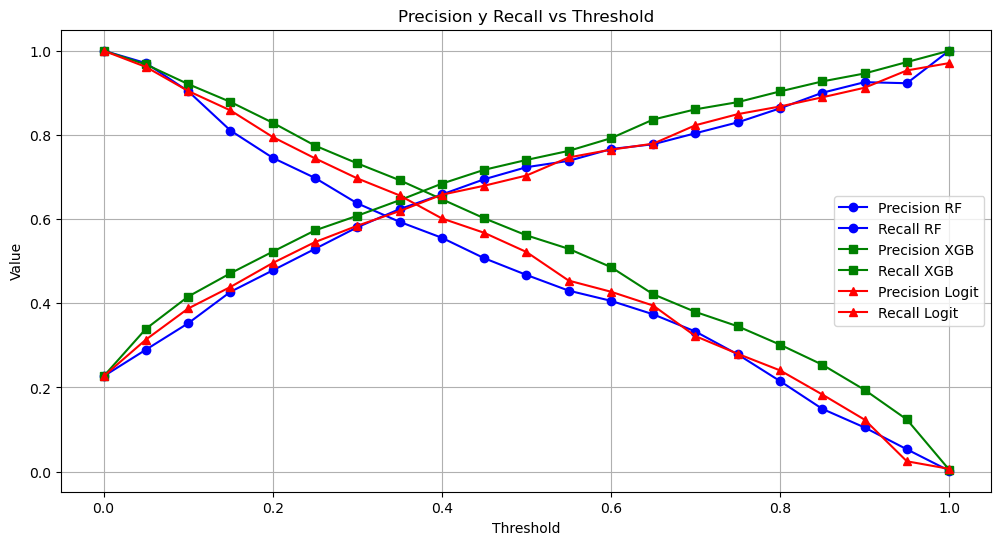

In [56]:
# graficas df_thresholds
plt.figure(figsize=(12, 6))
plt.plot(df_thresholds['threshold'], df_thresholds['precision_rf'], label='Precision RF', marker='o', color='blue')
plt.plot(df_thresholds['threshold'], df_thresholds['recall_rf'], label='Recall RF', marker='o', color='blue')
plt.plot(df_thresholds['threshold'], df_thresholds['precision_xgb'], label='Precision XGB', marker='s', color='green')
plt.plot(df_thresholds['threshold'], df_thresholds['recall_xgb'], label='Recall XGB', marker='s', color='green')
plt.plot(df_thresholds['threshold'], df_thresholds['precision_logit'], label='Precision Logit', marker='^', color='red')
plt.plot(df_thresholds['threshold'], df_thresholds['recall_logit'], label='Recall Logit', marker='^', color='red')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision y Recall vs Threshold')
plt.legend()
plt.grid()
plt.show()


Curva Precision-Recall por Threshold para RandomForest_Optimized_Calibrated_Isotonic:


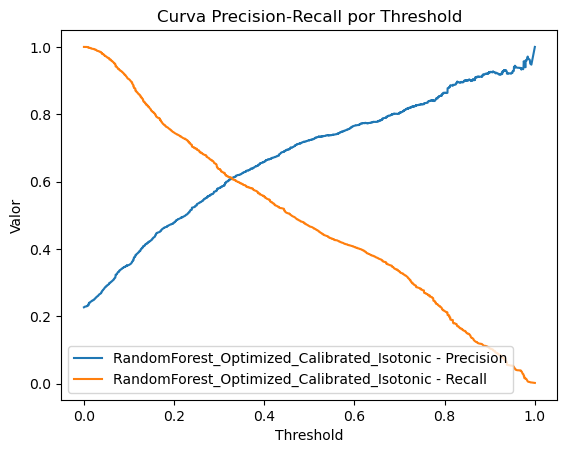


Curva Precision-Recall por Threshold para LogisticRegression_Optimized_Calibrated_Isotonic:


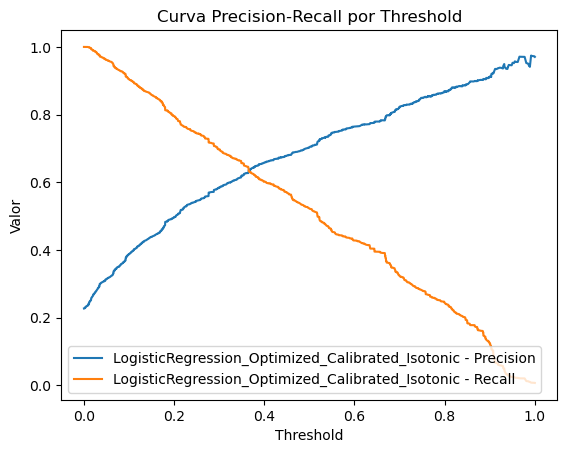


Curva Precision-Recall por Threshold para XGBoost_Optimized_Calibrated_Isotonic:


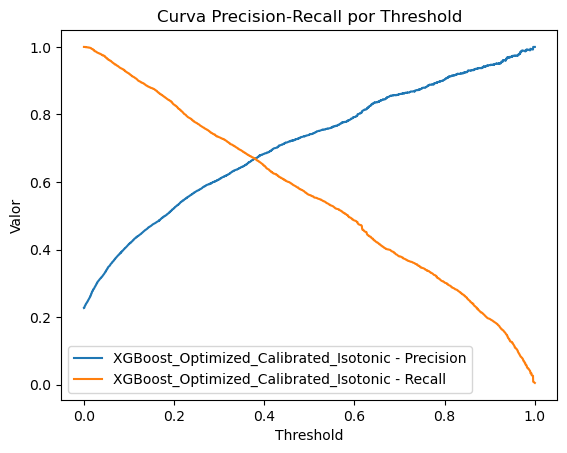

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall_curve_threshold(y_true, y_prob, label=None):
    """
    Traza la curva Precision-Recall para valores verdaderos y probabilidades predichas.
    Si se proporciona un 'label', se usa como etiqueta en la leyenda.
    """
    # Obtener los valores de precisión, recall y thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    # Traza la curva Precision-Recall para cada threshold
    plt.plot(thresholds, precision[:-1], label=f'{label} - Precision' if label else 'Precision')  # Excluye el último umbral
    plt.plot(thresholds, recall[:-1], label=f'{label} - Recall' if label else 'Recall')  # Excluye el último umbral

    plt.xlabel('Threshold')
    plt.ylabel('Valor')
    plt.title('Curva Precision-Recall por Threshold')
    plt.legend(loc='lower left')
    plt.show()

# Graficar Precision-Recall Curve por Threshold para modelos calibrados isotónicos
for model_name in ['RandomForest_Optimized_Calibrated_Isotonic',
                   'LogisticRegression_Optimized_Calibrated_Isotonic',
                   'XGBoost_Optimized_Calibrated_Isotonic']:
    print(f"\nCurva Precision-Recall por Threshold para {model_name}:")
    plot_precision_recall_curve_threshold(y_test, predictions[model_name][1], label=model_name)

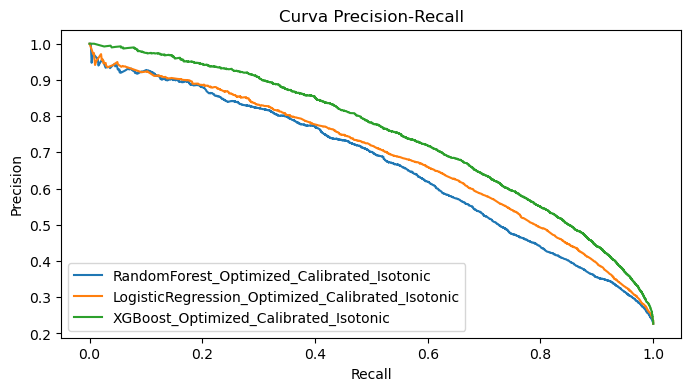

In [ ]:
# Precision-Recall Curve for calibrated models
plt.figure(figsize=(8, 4))
for model_name in ['RandomForest_Optimized_Calibrated_Isotonic',
                   'LogisticRegression_Optimized_Calibrated_Isotonic',
                   'XGBoost_Optimized_Calibrated_Isotonic']:
    metrics_utils.plot_precision_recall_curve(y_test, predictions[model_name][1], label=model_name)
plt.show()

## 7. Conclusiones Generales y Selección del Modelo Final

### 7.1 Resumen del Proceso Realizado

Este trabajo abordó el problema de **predicción de lluvia en Australia** mediante un enfoque sistemático que incluyó las siguientes etapas:

1. **Análisis Exploratorio de Datos (EDA):**
   - Identificamos un dataset con 145,460 observaciones y 23 variables
   - Detectamos desbalance de clases: aproximadamente 77% No lluvia vs 23% Sí lluvia
   - Encontramos valores faltantes significativos en 4 variables (>30%): Sunshine, Evaporation, Cloud9am, Cloud3pm
   - Identificamos outliers extremos en Rainfall (~17% de casos) y variables de viento

2. **Preprocesamiento de Datos:**
   - Eliminamos columnas con >30% de valores faltantes
   - Aplicamos imputación forward-fill (límite 7 días) respetando la naturaleza temporal de los datos
   - Discretizamos Rainfall en categorías (No Rain, Light Rain, Moderate Rain, Heavy Rain) para controlar outliers
   - Aplicamos capping en percentil 99 para variables de viento
   - Realizamos one-hot encoding para variables categóricas y StandardScaler para numéricas

3. **Entrenamiento de Modelos Base:**
   Evaluamos 5 algoritmos de clasificación:
   - Regresión Logística
   - Naive Bayes Gaussiano
   - K-Nearest Neighbors (KNN)
   - Random Forest
   - XGBoost

4. **Optimización de Hiperparámetros:**
   - Utilizamos búsqueda bayesiana con Optuna
   - Aplicamos TimeSeriesSplit (5 folds) para validación temporal
   - Optimizamos los 3 mejores modelos: XGBoost, Random Forest y Logistic Regression

5. **Calibración de Probabilidades:**
   - Aplicamos Isotonic Regression para mejorar la confiabilidad de las probabilidades predichas
   - Evaluamos el impacto en Brier Score y otras métricas

### 7.2 Comparación de Resultados

#### **Evolución de los Modelos:**

**Modelos Base (sin optimización):**
- XGBoost, Random Forest y Logistic Regression mostraron ROC-AUC superior (>0.86)
- KNN y Naive Bayes tuvieron desempeño inferior en discriminación
- Todos los modelos mostraron recall relativamente bajo, indicando dificultad para detectar eventos de lluvia

**Modelos Optimizados (con Hyperparameter Tuning):**
- **Recall aumentó significativamente:** mejora de aproximadamente +50% relativo
- **ROC-AUC mejoró:** especialmente en XGBoost y Random Forest
- **Trade-off esperado:** Precision disminuyó y Brier Score empeoró ligeramente
- El modelo prioriza ahora la **detección de eventos de lluvia** (objetivo del problema)

**Modelos Calibrados (Isotonic Regression):**
- **Brier Score mejoró dramáticamente:** reducción de aproximadamente -30% en XGBoost y Random Forest
- **Precision aumentó:** mejora de aproximadamente +30% relativo
- **Recall disminuyó moderadamente:** trade-off aceptable para obtener probabilidades confiables
- Las probabilidades predichas son ahora más confiables para toma de decisiones

### 7.3 Modelo Seleccionado: **XGBoost Optimizado con Calibración Isotónica**

#### **Justificación de la Elección:**

**1. Mejor Desempeño Global:**
- Mejor capacidad de discriminación entre clases (ROC-AUC más alto)
- Probabilidades mejor calibradas (Brier Score más bajo)
- Mejor balance precision-recall (F1-Score más alto entre modelos calibrados)
- Alta confiabilidad en predicciones positivas (reduce falsos positivos)

**2. Ventajas para el Problema de Negocio:**
- **Probabilidades confiables:** Brier Score bajo permite establecer umbrales de decisión personalizados
- **Balance precision-recall:** Mejor compromiso entre detectar lluvia y evitar falsas alarmas
- **Robustez ante desbalance:** Maneja efectivamente la proporción desbalanceada de las clases

**3. Interpretabilidad y Confianza:**
- La calibración isotónica ajusta las probabilidades sin perder capacidad discriminativa
- Permite comunicar riesgos de lluvia de forma más precisa a usuarios finales
- Facilita la integración en aplicaciones meteorológicas con umbrales ajustables

#### **Comparación con Alternativas:**

XGBoost Calibrated superó consistentemente a:
- **Random Forest Calibrated:** en ROC-AUC, Brier Score, F1-Score y Recall
- **Logistic Regression Calibrated:** en todas las métricas evaluadas

### 7.4 Recomendaciones Finales

1. **Implementación:** Utilizar el modelo XGBoost Calibrated para predicciones en producción
2. **Umbrales personalizados:** Ajustar threshold según contexto (ej: 0.3 para alertas tempranas, 0.7 para confirmaciones)
3. **Monitoreo continuo:** Evaluar desempeño periódicamente con nuevos datos para detectar drift
4. **Mejoras futuras:** 
   - Incorporar variables meteorológicas adicionales (imágenes satelitales, datos de radar)
   - Explorar modelos de series temporales (LSTM, Prophet) para capturar patrones estacionales
   - Implementar ensemble stacking combinando XGBoost + Random Forest

### 7.5 Lecciones Aprendidas

- El **desbalance de clases** requiere métricas especializadas (ROC-AUC, F1-Score) más allá de Accuracy
- El **hyperparameter tuning** puede mejorar significativamente el recall priorizando la detección de eventos raros
- La **calibración de probabilidades** es crucial cuando las predicciones se usan para toma de decisiones
- La **validación temporal** (TimeSeriesSplit) es esencial en datos con estructura temporal para evitar data leakage
- El **trade-off precision-recall** debe alinearse con los objetivos del negocio (en este caso, priorizar detección de lluvia)